### Titanicデータへの依存関係をなくしつつ、FE,EDAをする

In [1]:
# Load in our libraries
#src:https://www.kaggle.com/ash316/eda-to-prediction-dietanic
import pandas as pd
import numpy as np
import re
import sklearn
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
# from sklearn.cross_validation import KFold

In [18]:
train_df=pd.read_csv('../datasets/titanic/train.csv')
test_df=pd.read_csv('../datasets/titanic/test.csv')
train=pd.read_csv('../datasets/titanic/train.csv')
test=pd.read_csv('../datasets/titanic/test.csv')


In [19]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [20]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
PassengerID=test['PassengerId']

In [22]:
def binaly_feature(df,in_col,type=float):
    '''typeが一致していれば、1をそうでなければ0を返す'''
    return df[in_col].apply(lambda x:1 if type(x)==type else 0)

def getColumnsWithMissingValuesList(df):
    return [col for col in df.columns if df[col].isnull().any()] 

def getObjectColumnsList(df):
    return [cname for cname in df.columns if df[cname].dtype == "object"]

def getNumericColumnsList(df):
    return [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]

def PerformOneHotEncoding(df,columnsToEncode):
    return pd.get_dummies(df,columns = columnsToEncode)

In [23]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [24]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [25]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


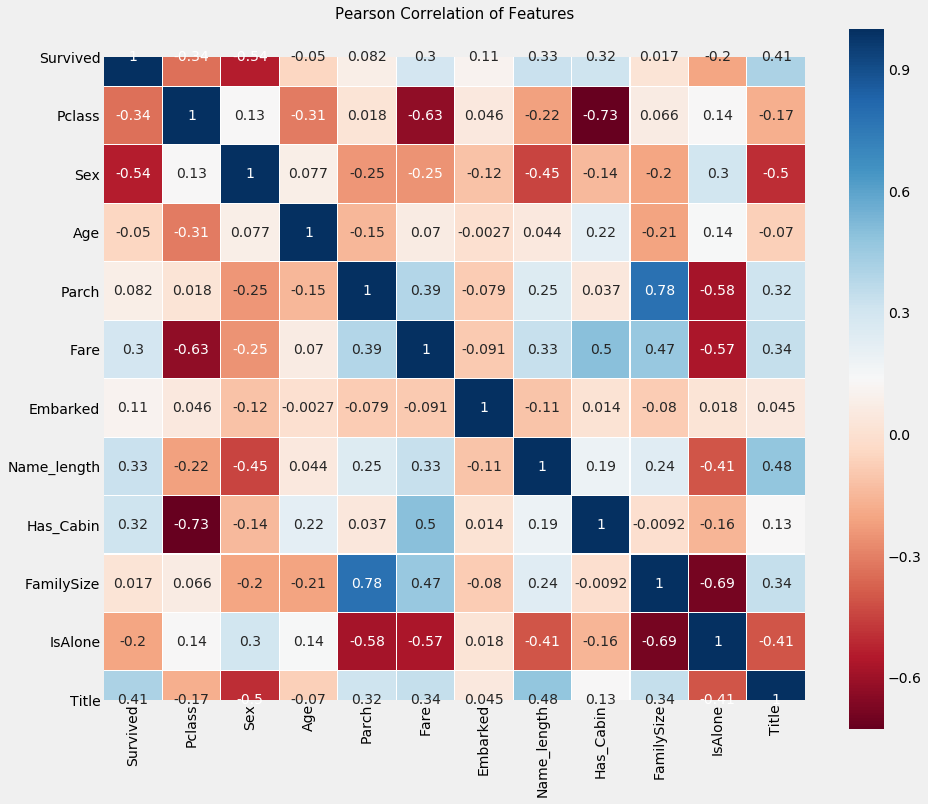

In [26]:
# train.astype(float).corr()
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [27]:
import seaborn as sns

In [28]:
tmp=train.groupby(['Sex'])['Sex','Survived'].count()


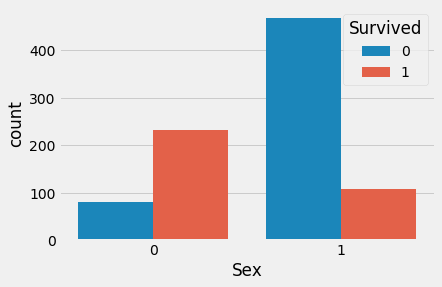

In [29]:
#クロス集計
plt.style.use('fivethirtyeight')
sns.countplot('Sex',hue='Survived',data=train)

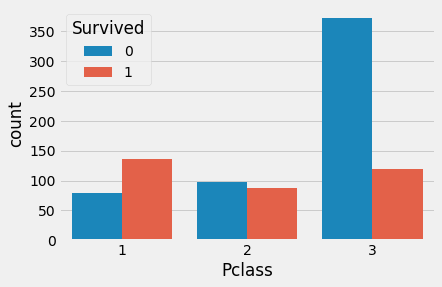

In [30]:
#categoricalにも使える
sns.countplot('Pclass',hue='Survived',data=train)

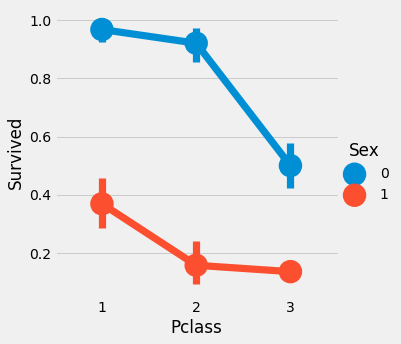

In [31]:
#categoryごとにどれくらいの比率で生き残ったかがわかる
sns.factorplot('Pclass','Survived',hue='Sex',data=train)

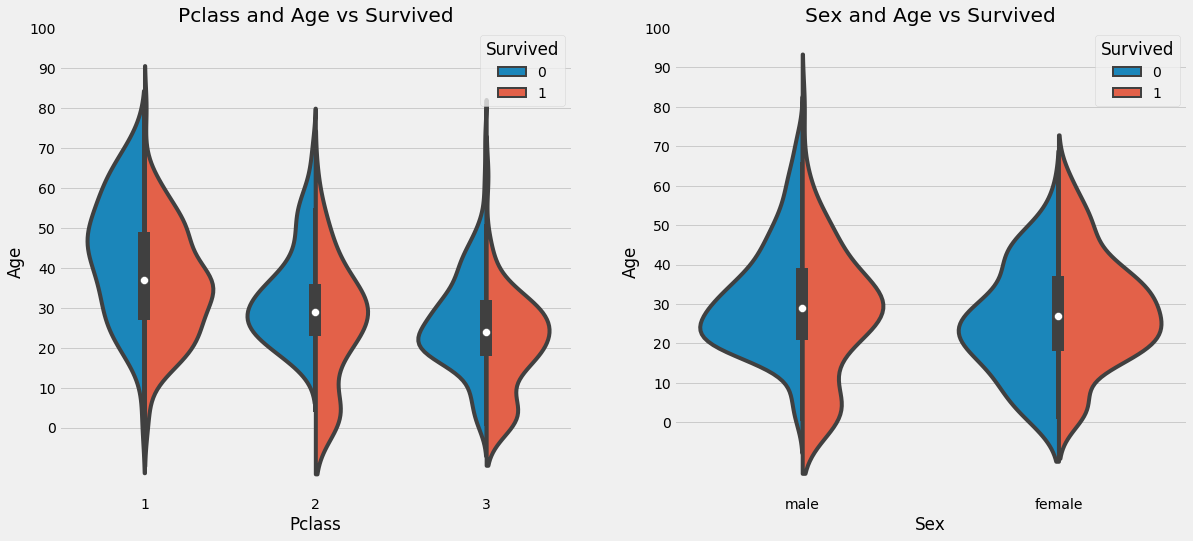

In [34]:
#二値分類のnumeric dataの分布を調べるやつ
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=train_df,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=train_df,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()


In [48]:

import sys
import pathlib
# base.pyのあるディレクトリの絶対パスを取得
current_dir = pathlib.Path('./').resolve().parent
# モジュールのあるパスを追加
sys.path.append(str(current_dir) + '/models')

from models.get_lgbm_params import get_lgbm_params
from models.predict import LGBMKfoldlgbPredictor

In [57]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import urllib.error
import urllib.request
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import re
import japanize_matplotlib
import gensim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
from sklearn.pipeline import Pipeline
import warnings
import lightgbm as lgb

In [110]:
lgbm_params=get_lgbm_params('binary',5)
lgbm_params

{'num_iterations': 500,
 'learning_rate': 0.08,
 'objective': 'binary',
 'metric': {'binary_error', 'binary_logloss'},
 'early_stopping_rounds': 30,
 'verbose': 1}

In [111]:
train_y=train['Survived'].values
train_X=train.drop(columns=['Survived']).values
test_X=test.values
clf=LGBMKfoldlgbPredictor(3,train_X,train_y,test_X,steps=None,params=lgbm_params)

In [112]:
oof,pred,FIs=clf.predict(False)

[1]	valid_0's binary_logloss: 0.633789	valid_0's binary_error: 0.383838
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.607413	valid_0's binary_error: 0.383838
[3]	valid_0's binary_logloss: 0.58558	valid_0's binary_error: 0.265993
[4]	valid_0's binary_logloss: 0.567157	valid_0's binary_error: 0.242424
[5]	valid_0's binary_logloss: 0.55106	valid_0's binary_error: 0.232323
[6]	valid_0's binary_logloss: 0.538068	valid_0's binary_error: 0.198653
[7]	valid_0's binary_logloss: 0.527071	valid_0's binary_error: 0.198653
[8]	valid_0's binary_logloss: 0.516432	valid_0's binary_error: 0.198653
[9]	valid_0's binary_logloss: 0.508499	valid_0's binary_error: 0.198653
[10]	valid_0's binary_logloss: 0.501926	valid_0's binary_error: 0.198653
[11]	valid_0's binary_logloss: 0.496581	valid_0's binary_error: 0.208754
[12]	valid_0's binary_logloss: 0.490795	valid_0's binary_error: 0.205387
[13]	valid_0's binary_logloss: 0.486776	valid_0's binary_error: 0.208754
